Задачи для контрольной работы по нейронным сетям:

Требования:
* Используем для сдачи задания *.ipynb с сохранением выводов или *.pdf версию с графиками и кодом: google colaboratory, jupyter — рабочей(доступной — актуальной ссылкой на google colaboratory или git - не рабочая ссылка (не публичная) — оценивается как «0 баллов»)
* Используем только numpy для решения задачи и для генерации данных sklearn.
* Результаты в графиках и выводах
* срок сдачи: 7.11 - 23-59
* защита: 8.11 - с 12-00 до 13-00 ,  9.11 с 12-00 - 13-00 и 10.11 -  20-00 - 21-00  (Видео конференция ) - таблица для записи на защиту https://docs.google.com/spreadsheets/d/1EQZtDaAN8-uoRWecdw9b7hx0jWk3bokDJuT0VVpMSG4/edit?usp=sharing  (записываемся (ФИО) по 3 человека в слот не более )
* номер задачи для решения = Номер по журналу % 5 + 1


По журналу 4 номер

In [ ]:
print(4%5 + 1)

5


Задача 5: Многослойный перцептрон с ручным вычислением градиентов
1. Реализовать двухслойную сеть с обратным распространением:
2. Ручной расчет всех частных производных для весов скрытого и выходного слоев
3. Проверка сходимости для задачи регресии в серии из 10 повторных запусках(sklearn.datasets.make_regression — n_features=50, n_informative=1 + <день рождения>/2, noise=0.5 * <день рождения>) при трех разных n_samples= 1000 (100, 10000).
4. \* показать vanishing gradient problem для глубоких сетей


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
birth_day = 21
n_features = 50
n_informative = 1 + birth_day // 2
noise = 0.5 * birth_day

print("Параметры датасета:")
print(f"  n_features = {n_features}")
print(f"  n_informative = {n_informative}")
print(f"  noise = {noise}")

Параметры датасета:
  n_features = 50
  n_informative = 11
  noise = 10.5


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

In [ ]:
class TwoLayerPerceptron:
    def __init__(self, input_size, hidden_size, learning_rate=0.01):
        # Инициализация весов с значениями из стандартного нормального распределения (Xavier)
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / (input_size + hidden_size))
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, 1) * np.sqrt(2.0 / (hidden_size + 1))
        self.b2 = np.zeros((1, 1))

        self.learning_rate = learning_rate

        self.train_losses = []
        self.val_losses = []

    def forward(self, X):
        self.X = X

        # Скрытый слой
        self.z1 = X @ self.W1 + self.b1
        self.a1 = sigmoid(self.z1)

        # Выходной слой
        self.z2 = self.a1 @ self.W2 + self.b2
        self.y_pred = self.z2

        return self.y_pred

    def compute_loss(self, y_true, y_pred):
        loss = np.mean((y_pred - y_true) ** 2)
        return loss

    def backward(self, y_true):
        m = y_true.shape[0]

        # градиенты выходного слоя
        dz2 = (2.0 / m) * (self.y_pred - y_true)
        dW2 = self.a1.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)

        # градиенты скрытого слоя
        da1 = dz2 @ self.W2.T
        dz1 = da1 * sigmoid_derivative(self.z1)
        dW1 = self.X.T @ dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        return dW1, db1, dW2, db2

    def update_weights(self, dW1, db1, dW2, db2):
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train_step(self, X, y):
        y_pred = self.forward(X)
        loss = self.compute_loss(y, y_pred)
        dW1, db1, dW2, db2 = self.backward(y)
        self.update_weights(dW1, db1, dW2, db2)

        return loss

    def fit(self, X_train, y_train, X_val, y_val, epochs=1000, print_res=False):
        for epoch in range(epochs):
            # Обучение
            train_loss = self.train_step(X_train, y_train)
            self.train_losses.append(train_loss)

            # Валидация
            y_val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, y_val_pred)
            self.val_losses.append(val_loss)

            if print_res and (epoch % 200 == 0 or epoch == epochs - 1):
                print(f"Эпоха {epoch:4d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

    def predict(self, X):
        return self.forward(X)


In [ ]:
def run_experiment(n_samples, n_runs=10, hidden_size=30, epochs=1000):
    final_losses = []
    all_train_losses = []
    all_val_losses = []

    print(f"\n{'='*80}")
    print(f"Эксперимент: n_samples = {n_samples}")
    print(f"{'='*80}\n")

    for run in range(n_runs):
        print(f"Запуск {run + 1}/{n_runs}...", end=" ")

        # Генерация данных
        X, y = make_regression(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=n_informative,
            noise=noise,
            random_state=run
        )
        y = y.reshape(-1, 1)

        # Разделение на train/validation (80%/20%)
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=run
        )

        # Стандартизация данных
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_train = scaler_X.fit_transform(X_train)
        X_val = scaler_X.transform(X_val)
        y_train = scaler_y.fit_transform(y_train)
        y_val = scaler_y.transform(y_val)

        # Создание и обучение модели
        model = TwoLayerPerceptron(
            input_size=n_features,
            hidden_size=hidden_size,
            learning_rate=0.01
        )

        model.fit(X_train, y_train, X_val, y_val, epochs=epochs, print_res=False)

        final_loss = model.val_losses[-1]
        final_losses.append(final_loss)
        all_train_losses.append(model.train_losses)
        all_val_losses.append(model.val_losses)

        print(f"Финальная ошибка: {final_loss:.6f}")

    print(f"\n{'-'*80}")
    print(f"Статистика для n_samples = {n_samples}:")
    print(f"  Средняя ошибка: {np.mean(final_losses):.6f} ± {np.std(final_losses):.6f}")
    print(f"  Минимум: {np.min(final_losses):.6f}")
    print(f"  Максимум: {np.max(final_losses):.6f}")
    print(f"{'-'*80}")

    return final_losses, all_train_losses, all_val_losses

Проводим серию из 10 повторных запусков для трёх разных размеров выборки:
- n_samples = 100
- n_samples = 1000
- n_samples = 10000

In [ ]:
sample_sizes = [100, 1000, 10000]
results = {}

for n_samples in sample_sizes:
    final_losses, train_losses, val_losses = run_experiment(
        n_samples=n_samples,
        n_runs=10,
        hidden_size=30,
        epochs=1000,
    )
    results[n_samples] = {
        'final_losses': final_losses,
        'train_losses': train_losses,
        'val_losses': val_losses
    }


Эксперимент: n_samples = 100

Запуск 1/10... Финальная ошибка: 0.252709
Запуск 2/10... Финальная ошибка: 0.166950
Запуск 3/10... Финальная ошибка: 0.143885
Запуск 4/10... Финальная ошибка: 0.071748
Запуск 5/10... Финальная ошибка: 0.177070
Запуск 6/10... Финальная ошибка: 0.105869
Запуск 7/10... Финальная ошибка: 0.057697
Запуск 8/10... Финальная ошибка: 0.263888
Запуск 9/10... Финальная ошибка: 0.163054
Запуск 10/10... Финальная ошибка: 0.205969

--------------------------------------------------------------------------------
Статистика для n_samples = 100:
  Средняя ошибка: 0.160884 ± 0.065792
  Минимум: 0.057697
  Максимум: 0.263888
--------------------------------------------------------------------------------

Эксперимент: n_samples = 1000

Запуск 1/10... Финальная ошибка: 0.012438
Запуск 2/10... Финальная ошибка: 0.016003
Запуск 3/10... Финальная ошибка: 0.010950
Запуск 4/10... Финальная ошибка: 0.013691
Запуск 5/10... Финальная ошибка: 0.016127
Запуск 6/10... Финальная ошибка:

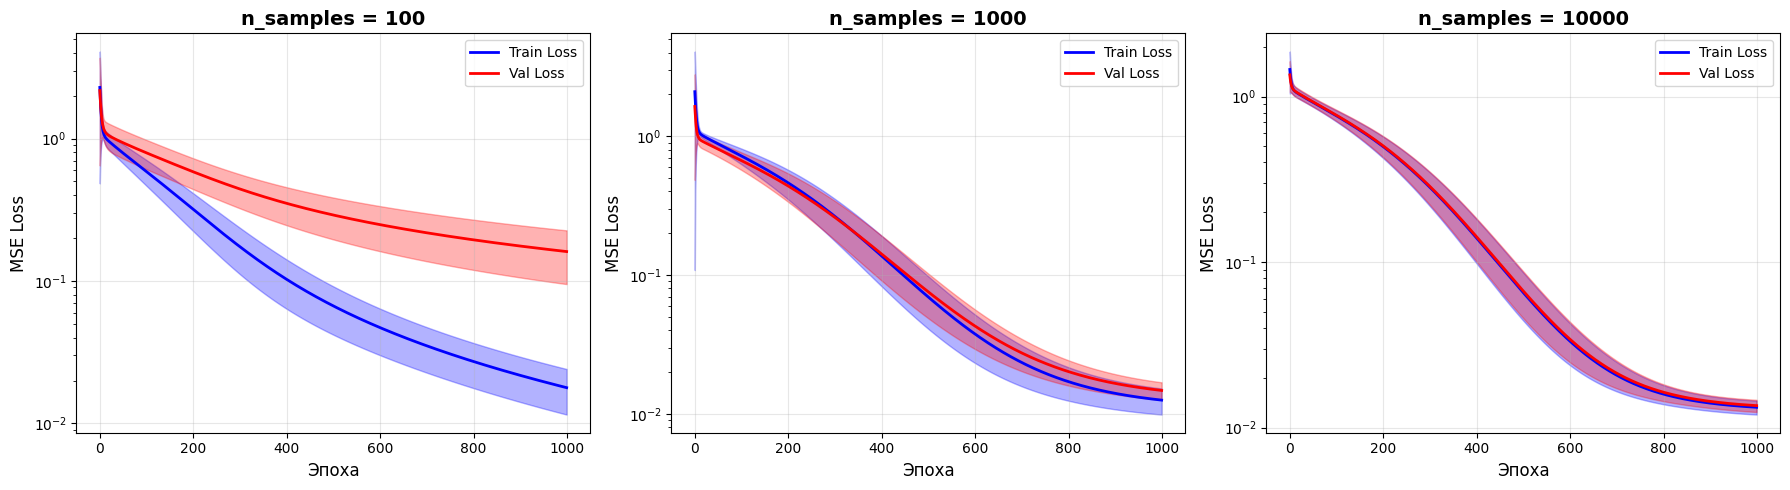

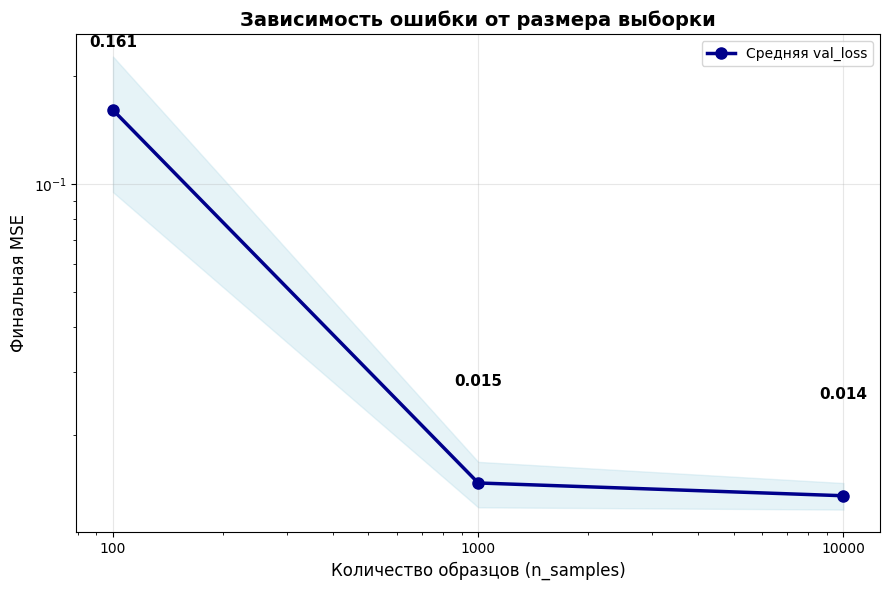

In [ ]:
# График 1: Кривые обучения для разных n_samples
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, n_samples in enumerate(sample_sizes):
    ax = axes[idx]
    train_losses = results[n_samples]['train_losses']
    val_losses = results[n_samples]['val_losses']

    # Усредненные кривые
    mean_train = np.mean(train_losses, axis=0)
    mean_val = np.mean(val_losses, axis=0)
    std_train = np.std(train_losses, axis=0)
    std_val = np.std(val_losses, axis=0)

    epochs_range = range(len(mean_train))

    # Средняя линия
    ax.plot(epochs_range, mean_train, label='Train Loss', linewidth=2, color='blue')
    ax.plot(epochs_range, mean_val, label='Val Loss', linewidth=2, color='red')

    # Доверительный интервал (среднее ± стандартное отклонение)
    ax.fill_between(epochs_range, mean_train - std_train, mean_train + std_train,
                     alpha=0.3, color='blue')
    ax.fill_between(epochs_range, mean_val - std_val, mean_val + std_val,
                     alpha=0.3, color='red')

    ax.set_xlabel('Эпоха', fontsize=12)
    ax.set_ylabel('MSE Loss', fontsize=12)
    ax.set_title(f'n_samples = {n_samples}', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

# График 2: Средняя ошибка в зависимости от размера выборки
fig, ax = plt.subplots(figsize=(9, 6))

means = []
stds = []

for n_samples in sample_sizes:
    losses = results[n_samples]['final_losses']
    means.append(np.mean(losses))
    stds.append(np.std(losses))

# Основная линия: средняя ошибка
ax.plot(sample_sizes, means, 'o-', color='darkblue', linewidth=2.5, markersize=8, label='Средняя val_loss')

# Разброс: ± стандартное отклонение
ax.fill_between(sample_sizes,
                np.array(means) - np.array(stds),
                np.array(means) + np.array(stds),
                alpha=0.3, color='lightblue')

for n, m, s in zip(sample_sizes, means, stds):
    ax.text(n, m + s + 0.01, f'{m:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Количество образцов (n_samples)', fontsize=12)
ax.set_ylabel('Финальная MSE', fontsize=12)
ax.set_title('Зависимость ошибки от размера выборки', fontsize=14, fontweight='bold')

ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(True, alpha=0.3)
ax.legend()

ax.set_xticks(sample_sizes)
ax.set_xticklabels(sample_sizes)

plt.tight_layout()
plt.show()

In [ ]:
for n_samples in sample_sizes:
    losses = results[n_samples]['final_losses']
    print(f"n_samples = {n_samples}:")
    print(f"  Средняя ошибка: {np.mean(losses):.6f} ± {np.std(losses):.6f}")
    print(f"  Диапазон: [{np.min(losses):.6f}, {np.max(losses):.6f}]")
    print(f"  Коэфф. вариации: {(np.std(losses) / np.mean(losses) * 100):.2f}%")
    print()

n_samples = 100:
  Средняя ошибка: 0.160884 ± 0.065792
  Диапазон: [0.057697, 0.263888]
  Коэфф. вариации: 40.89%

n_samples = 1000:
  Средняя ошибка: 0.014749 ± 0.002132
  Диапазон: [0.010950, 0.018162]
  Коэфф. вариации: 14.46%

n_samples = 10000:
  Средняя ошибка: 0.013589 ± 0.001151
  Диапазон: [0.012342, 0.015768]
  Коэфф. вариации: 8.47%



## Вывод
---

**При увеличении размера выборки (`n_samples`)**:  
   - Уменьшается средняя ошибка на валидации  
   - Снижается разброс результатов между запусками  
   - Более стабильная сходимость  



In [ ]:
class DeepNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes) - 1
        self.learning_rate = learning_rate

        # Инициализация весов (Xavier)
        self.weights = []
        self.biases = []
        for i in range(self.num_layers):
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / (layer_sizes[i] + layer_sizes[i+1]))
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(W)
            self.biases.append(b)

        # Для анализа vanishing gradient problem
        self.gradient_norms = {i: [] for i in range(self.num_layers)}
        self.train_losses = []
        self.activations = []
        self.z_values = []

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        a = X

        for i in range(self.num_layers):
            z = a @ self.weights[i] + self.biases[i]
            self.z_values.append(z)
            if i == self.num_layers - 1:
                # линейная активация на выходе
                a = z
            else:
                # скрытые слои: сигмоида
                a = sigmoid(z)
            self.activations.append(a)
        return a

    def backward(self, y_true):
        m = y_true.shape[0]
        y_pred = self.activations[-1]
        # градиент функции потерь по выходу
        delta = (2.0 / m) * (y_pred - y_true)

        gradients_W = []
        gradients_b = []

        for i in range(self.num_layers - 1, -1, -1):
            # градиенты для текущего слоя
            dW = self.activations[i].T @ delta
            db = np.sum(delta, axis=0, keepdims=True)
            gradients_W.insert(0, dW)
            gradients_b.insert(0, db)

            self.gradient_norms[i].append(np.linalg.norm(dW))

            # распространяем ошибку на предыдущий слой
            if i > 0:
                delta = (delta @ self.weights[i].T) * sigmoid_derivative(self.z_values[i-1])

        return gradients_W, gradients_b

    def update_weights(self, gradients_W, gradients_b):
        for i in range(self.num_layers):
            self.weights[i] -= self.learning_rate * gradients_W[i]
            self.biases[i] -= self.learning_rate * gradients_b[i]

    def train_step(self, X, y):
        y_pred = self.forward(X)
        loss = np.mean((y_pred - y) ** 2)
        self.train_losses.append(loss)
        gradients_W, gradients_b = self.backward(y)
        self.update_weights(gradients_W, gradients_b)
        return loss

    def fit(self, X, y, epochs=1000):
        for _ in range(epochs):
            self.train_step(X, y)

In [ ]:
# Генерация данных
X, y = make_regression(n_samples=1000, n_features=n_features, n_informative=n_informative, noise=noise, random_state=42)
y = y.reshape(-1, 1)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# 1 скрытый слой
shallow_net = DeepNeuralNetwork([50, 30, 1], learning_rate=0.01)
shallow_net.fit(X, y, epochs=1000)

# 8 скрытых слоёв
deep_net = DeepNeuralNetwork([50, 40, 35, 30, 25, 20, 15, 10, 5, 1], learning_rate=0.01)
deep_net.fit(X, y, epochs=1000)

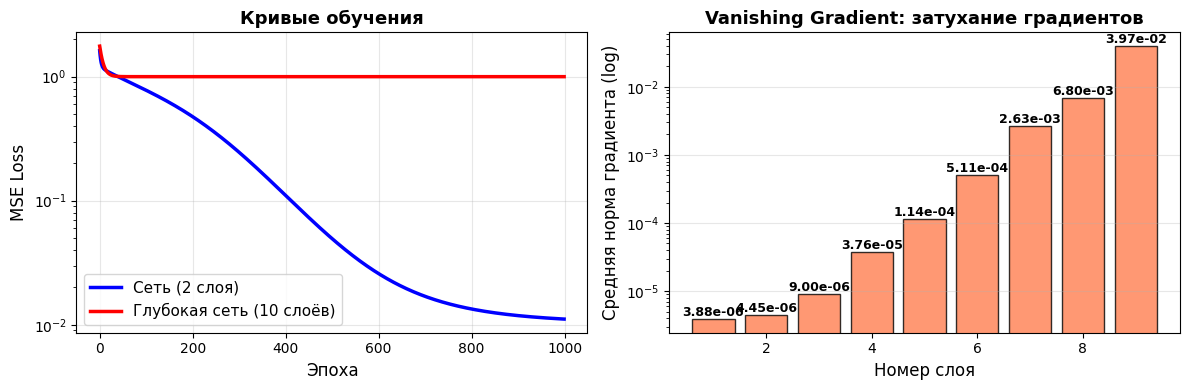

In [ ]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(shallow_net.train_losses, label='Сеть (2 слоя)', linewidth=2.5, color='blue')
plt.plot(deep_net.train_losses, label=f'Глубокая сеть ({deep_net.num_layers + 1} слоёв)', linewidth=2.5, color='red')
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Кривые обучения', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 2, 2)
layer_indices = list(range(1, deep_net.num_layers + 1))
avg_grad_norms = [np.mean(deep_net.gradient_norms[i]) for i in range(deep_net.num_layers)]

bars = plt.bar(layer_indices, avg_grad_norms, color='coral', alpha=0.8, edgecolor='black', linewidth=1)
plt.xlabel('Номер слоя', fontsize=12)
plt.ylabel('Средняя норма градиента (log)', fontsize=12)
plt.title('Vanishing Gradient: затухание градиентов', fontsize=13, fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, avg_grad_norms):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.2e}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Финальные ошибки
print(f"Сеть (2 слоя):  MSE = {shallow_net.train_losses[-1]:.6f}")
print(f"Глубокая сеть ({deep_net.num_layers + 1} слоёв): MSE = {deep_net.train_losses[-1]:.6f}")

print("-" * 80)
print("Средние нормы градиентов по слоям:")
avg_grad_norms = [np.mean(deep_net.gradient_norms[i]) for i in range(deep_net.num_layers)]

for i, norm in enumerate(avg_grad_norms):
    print(f"  Слой {i+1:>2} -- {norm:.2e}")

ratio = avg_grad_norms[-1] / avg_grad_norms[0]
print("-" * 80)
print(f"Градиент 1-го слоя в {ratio:,.0f} раз меньше градиента выходного")

Сеть (2 слоя):  MSE = 0.011105
Глубокая сеть (10 слоёв): MSE = 0.999999
--------------------------------------------------------------------------------
Средние нормы градиентов по слоям:
  Слой  1 -- 3.88e-06
  Слой  2 -- 4.45e-06
  Слой  3 -- 9.00e-06
  Слой  4 -- 3.76e-05
  Слой  5 -- 1.14e-04
  Слой  6 -- 5.11e-04
  Слой  7 -- 2.63e-03
  Слой  8 -- 6.80e-03
  Слой  9 -- 3.97e-02
--------------------------------------------------------------------------------
Градиент 1-го слоя в 10,242 раз меньше градиента выходного
